In [7]:
from tqdm.notebook import tqdm
from PIL import Image
import pandas as pd
import os
import numpy as np

#transforming images into processible numpy array
def load_data(folder):
    images = []
    for file in tqdm(os.listdir(folder)):
        file_id = file.replace('.png', '')
        image = Image.open(
            os.path.join(folder, file)
        ).convert('LA').resize((256, 256))
        arr = np.array(image)
        images.append(
            (int(file_id), arr)
        )
    images.sort(key=lambda i: i[0])
    return np.array([v for _id, v in images])


#load training dataset and label
x_train = load_data('A3/train')
y_train = pd.read_csv('A3/y_train.csv')['infection']

  0%|          | 0/487 [00:00<?, ?it/s]

In [17]:
#load test dataset
x_test = load_data('A3/test')

  0%|          | 0/210 [00:00<?, ?it/s]

What is the input? What is the output? What data mining function is required? What could be the challenges? What is the impact? What is an ideal solution?<br>
Input: X-ray images for covid and non-covid patients<br>
Output: Whether the image represent a symptom in covid<br>
Chanllenge: find the most suitable parameters(learning rate, hidden layer size etc), data augumentation and choosing the right formulation for the covolution and pooling layer.<br>
Impact: Multiple parameter tuning cycle has to be done to find a optimized way to train the models<br>
Ideal solution: The model is able to differentiate non-covid and covid X-ray images with no error.<br>


Q:What is the experimental protocol used and how was it carried out? <br>
A:The purporse of the experiment is to find out better parameters for the covid X-ray image prediction.
The materials are pre-splitted datasets train and test containing images data. The evironment is prebuilt A3_template.ipynb google colab notebook.<br>
Q:How did we tune hyper-parameters in the template? <br>
A: Fine tuning by gridsearch or manually. Set a few options as search space, and use the optimal one with highest accuracy but not overfitting.<br>
Q:What is the search space and what is the criteria to determine good/bad hyper-parameters?<br>
A: The search space is listed in the code block, the criteria to determine good/bad parameters is the training accuracy(score) using the parameter chosen.


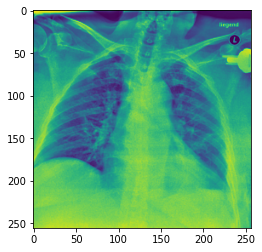

In [8]:
# check image 
import matplotlib.pyplot as plt
plt.imshow(x_train[0, :, :, 0])

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, Input

#the example given has 2 fully connected layer and an output layer, these three layers has learnable parameters(weights)
def build():
    img_in = Input(shape=(256, 256, 2))
    flattened = Flatten()(img_in)
    fc1 = Dense(64)(flattened)
    #fc1 = Dropout(0.3)(fc1)
    fc2 = Dense(32)(fc1)
    #fc2 = Dropout(0.3)(fc2)
    #fc3 = Dense(16)(fc2)
    #fc4 = Dense(8)(fc3)
    output = Dense(1, activation = 'sigmoid')(fc2)
    model = tf.keras.Model(inputs=img_in, outputs=output)
    return model


#start training
model = build()
model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['BinaryAccuracy', 'AUC']
        )

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 2)]     0         
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 64)                8388672   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8,390,785
Trainable params: 8,390,785
Non-trainable params: 0
_________________________________________________________________


In [10]:
epochs = 30
batch_size = 64

history = model.fit(x = x_train,
                    y = y_train,
                    batch_size = batch_size,
                    validation_split=0.3,
                    epochs=epochs
                    )

Epoch 1/30
6/6 [==============================] - 3s 73ms/step - loss: 76081.3672 - binary_accuracy: 0.6294 - auc: 0.5221 - val_loss: 15158.0918 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 2/30
6/6 [==============================] - 0s 14ms/step - loss: 53627.7422 - binary_accuracy: 0.4000 - auc: 0.4877 - val_loss: 21204.0000 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 3/30
6/6 [==============================] - 0s 14ms/step - loss: 27676.8438 - binary_accuracy: 0.6765 - auc: 0.5000 - val_loss: 5928.9014 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 4/30
6/6 [==============================] - 0s 16ms/step - loss: 16640.0293 - binary_accuracy: 0.3588 - auc: 0.4407 - val_loss: 11246.9297 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 5/30
6/6 [==============================] - 0s 15ms/step - loss: 12290.2842 - binary_accuracy: 0.6765 - auc: 0.5000 - val_loss: 2164.9746 - val_binary_accuracy: 0.6599 - val_auc: 0.5098
Epoch 6/30
6/6 [=====================

In [23]:
#install scikeras to prepare for the grid search method
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
#trial 1 fine tuning on the MLP model, which has 5 layers with 3 layers that have learnable parameters
#attempt to find the best batchsize and epochs
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
batchsize=[32,64,128,256]
epochs=[20,30,40,50]
def build():
    img_in = Input(shape=(256, 256, 2))
    flattened = Flatten()(img_in)
    fc1 = Dense(64)(flattened)
    #fc1 = Dropout(0.3)(fc1)
    fc2 = Dense(32)(fc1)
    #fc2 = Dropout(0.3)(fc2)
    #fc3 = Dense(16)(fc2)
    #fc4 = Dense(8)(fc3)
    output = Dense(1, activation = 'sigmoid')(fc2)
    model = tf.keras.Model(inputs=img_in, outputs=output)
    return model
#start trainiing
trial=build()
trial.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['BinaryAccuracy', 'AUC']
        )

trial1=KerasClassifier(model=trial)
param_grid = dict(batch_size=batchsize, epochs=epochs)
grid = GridSearchCV(estimator=trial1,param_grid=param_grid , n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#the final results returns that batch size32, epoch 40 is the best parameter

Epoch 1/40
16/16 [==============================] - 1s 7ms/step - loss: 48691.1953 - binary_accuracy: 0.5421 - auc_2: 0.4819
Epoch 2/40
16/16 [==============================] - 0s 8ms/step - loss: 5051.7358 - binary_accuracy: 0.5729 - auc_2: 0.5144
Epoch 3/40
16/16 [==============================] - 0s 6ms/step - loss: 1037.3076 - binary_accuracy: 0.6242 - auc_2: 0.5810
Epoch 4/40
16/16 [==============================] - 0s 6ms/step - loss: 963.0012 - binary_accuracy: 0.5934 - auc_2: 0.5454
Epoch 5/40
16/16 [==============================] - 0s 7ms/step - loss: 858.3020 - binary_accuracy: 0.6099 - auc_2: 0.5520
Epoch 6/40
16/16 [==============================] - 0s 6ms/step - loss: 1524.8334 - binary_accuracy: 0.5729 - auc_2: 0.5348
Epoch 7/40
16/16 [==============================] - 0s 7ms/step - loss: 590.0340 - binary_accuracy: 0.6530 - auc_2: 0.6119
Epoch 8/40
16/16 [==============================] - 0s 7ms/step - loss: 402.2276 - binary_accuracy: 0.6735 - auc_2: 0.6320
Epoch 9/40


In [40]:
#There is a big gap in validation accuracy and training accuracy in the previous trial and the example, indicating an overfitting happens

#trial 2, introduce data augumentation
#Since the data set is too small, more data is required for traininng
#at this stage , data augmentation would be good for allowing the model to adapt to shifted, rotated images in new dataset
#as well as reduce overfitting 
#creating data augmentation layer

from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.3),
])
#use a sequential operation to determine the 
trial2 = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  data_augmentation,
  build()
])



trial2.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['BinaryAccuracy', 'AUC']
        )
#start training 
epochs = 40
batch_size = 32

history = trial2.fit(x = x_train,
                    y = y_train,
                    batch_size = batch_size,
                    validation_split=0.3,
                    epochs=epochs
                    )
#Although the average training accuracy lowered, there is less gap between test validation and training accuracy, indicating an improvement in overfitting.

Epoch 1/40
11/11 [==============================] - 2s 58ms/step - loss: 80635.0312 - binary_accuracy: 0.6441 - auc: 0.5480 - val_loss: 3120.9363 - val_binary_accuracy: 0.3878 - val_auc: 0.4853
Epoch 2/40
11/11 [==============================] - 0s 35ms/step - loss: 10699.3770 - binary_accuracy: 0.5118 - auc: 0.5063 - val_loss: 5563.0664 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 3/40
11/11 [==============================] - 0s 34ms/step - loss: 6312.2676 - binary_accuracy: 0.6000 - auc: 0.5004 - val_loss: 2913.3479 - val_binary_accuracy: 0.3673 - val_auc: 0.5156
Epoch 4/40
11/11 [==============================] - 0s 33ms/step - loss: 4790.0732 - binary_accuracy: 0.4912 - auc: 0.4816 - val_loss: 9234.5791 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 5/40
11/11 [==============================] - 0s 35ms/step - loss: 5572.2256 - binary_accuracy: 0.6118 - auc: 0.5399 - val_loss: 3071.9580 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 6/40
11/11 [===============

In [42]:
#trial3 
#Based on trial2, the test accuracy improvement is still from 0.5 to near 0.6. 
#The loss starts to fluctuate around 1 in later epochs indicates convergence.
#Tweaking layers of network might improve the accuracy further
#Let's see if adding dropout layers solves the problem
def build_trial3():
    img_in = Input(shape=(256, 256, 2))
    flattened = Flatten()(img_in)
    fc1 = Dense(64)(flattened)
    fc1 = Dropout(0.3)(fc1)
    fc2 = Dense(32)(fc1)
    fc2 = Dropout(0.3)(fc2)
    #fc3 = Dense(16)(fc2)
    #fc4 = Dense(8)(fc3)
    output = Dense(1, activation = 'sigmoid')(fc2)
    model = tf.keras.Model(inputs=img_in, outputs=output)
    return model
trial3 = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  data_augmentation,
  build_trial3()
])



trial3.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['BinaryAccuracy', 'AUC']
        )
#start training 
epochs = 40
batch_size = 32

history = trial3.fit(x = x_train,
                    y = y_train,
                    batch_size = batch_size,
                    validation_split=0.3,
                    epochs=epochs
                    )
#Dropout layers reduces the neurons in dense layers thus less information is received by the network
#As a result, the scores reduces for the training accuracy which is normal. 
#However, the test accuracy didn't show progress but falls back a little bit.
#dropout layers are not valid solutions


Epoch 1/40
11/11 [==============================] - 2s 58ms/step - loss: 46424.0234 - binary_accuracy: 0.5382 - auc: 0.4785 - val_loss: 35304.5430 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 2/40
11/11 [==============================] - 0s 35ms/step - loss: 21633.7891 - binary_accuracy: 0.5676 - auc: 0.4931 - val_loss: 5620.4321 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 3/40
11/11 [==============================] - 0s 35ms/step - loss: 16118.6504 - binary_accuracy: 0.5676 - auc: 0.5097 - val_loss: 4414.9517 - val_binary_accuracy: 0.3673 - val_auc: 0.5018
Epoch 4/40
11/11 [==============================] - 0s 33ms/step - loss: 13019.9971 - binary_accuracy: 0.5500 - auc: 0.4800 - val_loss: 19410.2188 - val_binary_accuracy: 0.3469 - val_auc: 0.5000
Epoch 5/40
11/11 [==============================] - 0s 36ms/step - loss: 15501.8027 - binary_accuracy: 0.5029 - auc: 0.4642 - val_loss: 2552.8662 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 6/40
11/11 [==========

In [57]:
#trial4 
#Based on trial3, tweaking layers of network might improve the accuracy further
#Attempts on increasing more dense layers to improve the result

#the experiments starts at 2 fc layers, the model recompiles everytime we add a new layer
#by taking out the commented code, more layer is added
def build_trial4():
    img_in = Input(shape=(256, 256, 2))
    flattened = Flatten()(img_in)
    fc1 = Dense(64)(flattened)
    fc2 = Dense(32)(fc1)
    fc3 = Dense(32)(fc2)
    #fc3=Dense(16)(fc2)
    #fc4 = Dense(16)(fc3)
    #fc5= Dense(8)(fc4)
    output = Dense(1, activation = 'sigmoid')(fc3)
    model = tf.keras.Model(inputs=img_in, outputs=output)
    return model
trial4 = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  data_augmentation,
  build_trial4()
])



trial4.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['BinaryAccuracy', 'AUC']
        )
#start training 
epochs = 40
batch_size = 32

history = trial4.fit(x = x_train,
                    y = y_train,
                    batch_size = batch_size,
                    validation_split=0.3,
                    epochs=epochs
                    )
#The most suitable layer in this small search space is 4 layers as the code in build_trial4 shows, it has improved training accuracy 
#as well as validation accuracy, maintaining the same loss level before.

#Furthermore, if we add more layers to the model, the accuracy will starts to fall 
#and the gap between validation and training accuracy will increase
#indicating a sign of overfitting due to too much parameters


Epoch 1/40
11/11 [==============================] - 2s 57ms/step - loss: 57185.9766 - binary_accuracy: 0.5735 - auc: 0.4861 - val_loss: 53177.0117 - val_binary_accuracy: 0.3469 - val_auc: 0.5000
Epoch 2/40
11/11 [==============================] - 0s 35ms/step - loss: 29917.4414 - binary_accuracy: 0.5647 - auc: 0.4862 - val_loss: 2529.1311 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 3/40
11/11 [==============================] - 0s 34ms/step - loss: 11484.5879 - binary_accuracy: 0.5000 - auc: 0.4502 - val_loss: 4826.0615 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 4/40
11/11 [==============================] - 0s 33ms/step - loss: 5698.6655 - binary_accuracy: 0.5029 - auc: 0.4571 - val_loss: 4432.3989 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 5/40
11/11 [==============================] - 0s 38ms/step - loss: 2669.6663 - binary_accuracy: 0.5529 - auc: 0.5083 - val_loss: 2992.1655 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 6/40
11/11 [=============

🌈 What is the validation method used in the example template? Considering the dataset is a bit small, is it an appropriate approach? If not, what would you suggest? (you are not expected to change but you are allowed to do that if you want)<br>
A: It separates the training dataset by portion and creates new training and validation dataset. It is not a good solution for a small dataset like this since the model requires more information during training. A more suitable method would be cross-validation, which uses different protion of training data to train and validate the model.<br>
🌈What is the default model in the template? Is it a good one for image data? why?<br>
A:It isva multilayer perceptron(MLP). MLP is not a good one for image data since it is a fully connected neural network, there is too many paramters in the weights that may result in overfitting and too many computational time compare to convolutional neural network.<br>
🌈Convolution neural network address what issues of a fully connected neural network and how?<br>
A:Fully connected neural network suffer from overfitting due to too many parameters. CNN reduces the parameter number by applying convolutional and pooling filters.Also, Fully connected neural network is not adaptive to data invariants(shifts/rotations in image etc), but CNN overcome this problem by applying number of convolutional filter to the data , which learns the data pattern in a number of scales that includes the invariant senarios.<br>
🌈What's the different between 1d, 2d, and 3d convolution?<br>
A:They differ in the input and output dimensions. 1d only has the width dimension,2d has the height and width dimension, and 3d has an additional depth dimension added on the 2d dimension.<br>
🌈What is the difference between convolution and pooling?<br>
A: Convolutional layer has learnable parameters (weight update) but pooling layer is just applying exsiting function on the input.

In [73]:
#trial5 Covolutional neural network
#MLP is not a very suitable method to this question, as the questions above explains
#Therefore, it is necessary to establish a new neural network for this question using convolutional and pooling layer

def conv_build():
    img_in = Input(shape=(64, 64, 8))#compact with the convolutional layer output
    flattened = Flatten()(img_in)
    fc1 = Dense(16)(flattened)
    fc2 = Dense(8)(fc1)
    #fc3 = Dense(32)(fc2)
    #fc3=Dense(16)(fc2)
    #fc4 = Dense(16)(fc3)
    #fc5= Dense(8)(fc4)
    output = Dense(1, activation = 'sigmoid')(fc2)
    model = tf.keras.Model(inputs=img_in, outputs=output)
    return model
Conv = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  data_augmentation,
  #convolutional and pooling layer
  layers.Conv2D(8, 4, strides=(2,2),padding='same', activation='relu'),#output shape (256-4)/2+1=127
  layers.MaxPooling2D(),#output shape (127-2+1)/2=64
  #fully connected layer
  conv_build()
])
Conv.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['BinaryAccuracy', 'AUC']
        )
#start training 
epochs = 40
batch_size = 32

history = Conv.fit(x = x_train,
                    y = y_train,
                    batch_size = batch_size,
                    validation_split=0.3,
                    epochs=epochs
                    )
#compare to the initial result of the example, the convolutional approach increases the train and validation accuracy greatly
#Since the validation/train accuracy gap is low and the loss is low, we can say that overfitting is not the case here.

Epoch 1/40
11/11 [==============================] - 2s 71ms/step - loss: 2384.3174 - binary_accuracy: 0.5647 - auc: 0.5099 - val_loss: 2020.9371 - val_binary_accuracy: 0.3469 - val_auc: 0.5000
Epoch 2/40
11/11 [==============================] - 0s 45ms/step - loss: 689.9786 - binary_accuracy: 0.6353 - auc: 0.5289 - val_loss: 163.9494 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 3/40
11/11 [==============================] - 0s 43ms/step - loss: 136.3272 - binary_accuracy: 0.5500 - auc: 0.5061 - val_loss: 37.3382 - val_binary_accuracy: 0.6599 - val_auc: 0.5322
Epoch 4/40
11/11 [==============================] - 1s 48ms/step - loss: 48.1277 - binary_accuracy: 0.5941 - auc: 0.5281 - val_loss: 36.5147 - val_binary_accuracy: 0.4422 - val_auc: 0.5433
Epoch 5/40
11/11 [==============================] - 1s 46ms/step - loss: 25.8039 - binary_accuracy: 0.5765 - auc: 0.5495 - val_loss: 12.6008 - val_binary_accuracy: 0.5646 - val_auc: 0.5890
Epoch 6/40
11/11 [==============================

In [79]:
#trial6 Covolutional neural network
#Tuning paramters to find the best batch size and epoch, since there  is potential improvement in accuracy
#since there is problem for sequential object use gridsearch(probably a bug), I will do it manually

def conv_build():
    img_in = Input(shape=(64, 64, 8))#compact with the convolutional layer output
    flattened = Flatten()(img_in)
    fc1 = Dense(16)(flattened)
    fc2 = Dense(8)(fc1)
    #fc3 = Dense(32)(fc2)
    #fc3=Dense(16)(fc2)
    #fc4 = Dense(16)(fc3)
    #fc5= Dense(8)(fc4)
    output = Dense(1, activation = 'sigmoid')(fc2)
    model = tf.keras.Model(inputs=img_in, outputs=output)
    return model
Conv = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  data_augmentation,
  #convolutional and pooling layer
  layers.Conv2D(8, 4, strides=(2,2),padding='same', activation='relu'),#output shape (256-4)/2+1=127
  layers.MaxPooling2D(),#output shape (127-2+1)/2=64
  #fully connected layer
  conv_build()
])
Conv.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['BinaryAccuracy', 'AUC']
        )
#start training 
epochs = 40
batch_size = 32

history = Conv.fit(x = x_train,
                    y = y_train,
                    batch_size = batch_size,
                    validation_split=0.3,
                    epochs=epochs
                    )
#epoch optimization (batch=32)
#epoch 30 accuracy 0.5794 
#epoch 40 accuracy 0.6539, loss <1
#epoch 50 accuracy 0.5200, loss>1
#batchsize optimization(epoch 40)
#batch 64 accuracy 0.6101  gap between validation and training accuracy increases
#batch 128 accuracy 0.5590 

#thus in this search space, the best figure is still epoch=40, batchsize=32

Epoch 1/40
11/11 [==============================] - 2s 72ms/step - loss: 563.6052 - binary_accuracy: 0.6147 - auc: 0.5180 - val_loss: 73.9713 - val_binary_accuracy: 0.3469 - val_auc: 0.5000
Epoch 2/40
11/11 [==============================] - 1s 48ms/step - loss: 54.9618 - binary_accuracy: 0.5706 - auc: 0.5308 - val_loss: 18.4730 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 3/40
11/11 [==============================] - 0s 44ms/step - loss: 7.5497 - binary_accuracy: 0.4706 - auc: 0.4774 - val_loss: 3.7617 - val_binary_accuracy: 0.6531 - val_auc: 0.5098
Epoch 4/40
11/11 [==============================] - 1s 47ms/step - loss: 3.2248 - binary_accuracy: 0.6618 - auc: 0.4839 - val_loss: 1.6019 - val_binary_accuracy: 0.3401 - val_auc: 0.5561
Epoch 5/40
11/11 [==============================] - 0s 43ms/step - loss: 1.4930 - binary_accuracy: 0.5324 - auc: 0.5005 - val_loss: 1.2845 - val_binary_accuracy: 0.6463 - val_auc: 0.6191
Epoch 6/40
11/11 [==============================] - 1s 46ms/

In [88]:
#trial7 Covolutional neural network
#Increasing number of layers and adjusting filters to retrieve more information about the dataset
#thus improve the accuracy
def conv_build_trial7():
    img_in = Input(shape=(32, 32, 32))#compact with the convolutional layer output
    flattened = Flatten()(img_in)
    fc1 = Dense(16)(flattened)
    fc2 = Dense(8)(fc1)
    #fc3 = Dense(32)(fc2)
    #fc3=Dense(16)(fc2)
    #fc4 = Dense(16)(fc3)
    #fc5= Dense(8)(fc4)
    output = Dense(1, activation = 'sigmoid')(fc2)
    model = tf.keras.Model(inputs=img_in, outputs=output)
    return model
Conv_7 = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  data_augmentation,
  #convolutional and pooling layer 
  #filter=[(16,32),(8,16),(32,64)] are tested
  layers.Conv2D(16, 4, strides=(2,2),padding='same', activation='relu'),#output shape (256-4)/2+1=127
  layers.MaxPooling2D(),#output shape (127-2+1)/2=64
  layers.Conv2D(32, 3, strides=(1,1),padding='same', activation='relu'),#output shape (64-3)/1+1=62
  layers.MaxPooling2D(),#output shape (62-2+1)/2=32
  #fully connected layer
  conv_build_trial7()
])
Conv_7.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['BinaryAccuracy', 'AUC']
        )
#start training 
epochs = 40
batch_size = 32

history = Conv_7.fit(x = x_train,
                    y = y_train,
                    batch_size = batch_size,
                    validation_split=0.3,
                    epochs=epochs
                    )
#For filter(16,32),the accuracy floats around 0.65~0.7, the he train/validation accuracy gap is not as large
#For filter(8,16),the accuracy floats around 0.6~0.65, and the train/validation accuracy has large gap between
#For filter(32,64),the accuracy floats around 0.6~0.65, and the train/validation accuracy has large gap between


Epoch 1/40
11/11 [==============================] - 2s 86ms/step - loss: 303.9164 - binary_accuracy: 0.5853 - auc: 0.5479 - val_loss: 99.5407 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 2/40
11/11 [==============================] - 1s 51ms/step - loss: 40.0688 - binary_accuracy: 0.5882 - auc: 0.5297 - val_loss: 27.4481 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 3/40
11/11 [==============================] - 1s 50ms/step - loss: 11.4578 - binary_accuracy: 0.5471 - auc: 0.4712 - val_loss: 7.0574 - val_binary_accuracy: 0.6531 - val_auc: 0.5036
Epoch 4/40
11/11 [==============================] - 1s 58ms/step - loss: 4.4449 - binary_accuracy: 0.5500 - auc: 0.4548 - val_loss: 4.3878 - val_binary_accuracy: 0.6463 - val_auc: 0.5410
Epoch 5/40
11/11 [==============================] - 1s 76ms/step - loss: 1.9401 - binary_accuracy: 0.6235 - auc: 0.5950 - val_loss: 1.3957 - val_binary_accuracy: 0.6735 - val_auc: 0.6198
Epoch 6/40
11/11 [==============================] - 1s 77ms

In [89]:
y_test = Conv_7.predict(x_test)

y_test_df = pd.DataFrame()
y_test_df['id'] = np.arange(len(y_test))
y_test_df['infection'] = y_test.astype(float)
y_test_df.to_csv('submission.csv', index=False)
#I used the result for  trial4 in the submission
#I got to nervous and I mistake the file for several times thus it won't allow me to submit until 48 hours later
# I would very much want to see the result for the convolutional network, it should improve

7/7 [==============================] - 0s 19ms/step
